In [20]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display
import os

In [21]:
data_folder = "../../data"
n_buses = 118
num_samples = 30000

In [22]:
path_to_data = "/Users/apu/benchmark_data/pfdelta/30000opfv2dataset_case118_ieee.mat"
pfdelta_data = scipy.io.loadmat(path_to_data)
baseMVA = pfdelta_data["baseMVA"]

num_samples = pfdelta_data["Dem"].shape[1]
num_buses = pfdelta_data["bus"].shape[0]

Pd = np.real(pfdelta_data["Dem"]).flatten(order='F')
Qd = np.imag(pfdelta_data["Dem"]).flatten(order='F')
Pg_at_gens = np.real(pfdelta_data["Gen"])
Qg_at_gens = np.imag(pfdelta_data["Gen"])
Vm = np.abs(pfdelta_data["Vol"]).flatten(order='F')
Va = np.angle(pfdelta_data["Vol"]).flatten(order='F')
Va = np.rad2deg(Va)

gen_bus = pfdelta_data["gen"][:, 0].astype(int) - 1

Pg = np.zeros((num_buses, num_samples))
Qg = np.zeros((num_buses, num_samples))

Pg[gen_bus, :] = Pg_at_gens
Qg[gen_bus, :] = Qg_at_gens

Pg = Pg.flatten(order='F')
Qg = Qg.flatten(order='F')

df_delta = pd.DataFrame({
    "bus": np.tile(np.arange(num_buses), num_samples),
    "scenario": np.repeat(np.arange(num_samples), num_buses),
    "Pd": Pd / 100.0,
    "Qd": Qd / 100.0,
    "Pg": Pg / 100.0,
    "Qg": Qg / 100.0,
    "Vm": Vm,
    "Va": Va,
})



In [23]:
dataset_paths = os.listdir(data_folder)
dataset_paths = [os.path.join(data_folder, d, "case118_ieee/raw/bus_data.csv") for d in dataset_paths]


versions = {
    dataset_path.split("/")[-4]: dataset_path for dataset_path in dataset_paths

}

# keep only versions that exist
versions = {k: v for k, v in versions.items() if os.path.exists(v)}

# add pfdelta
versions["pfdelta"] = df_delta




In [24]:
versions.keys()

dict_keys(['baseline_perturbations_lines_only_k_5', 'baseline_perturbations_lines_only_k_5_sigma_3', 'baseline_perturbations_lines_only_k_5_generator_perturbation_1', 'baseline_perturbations_lines_only_k_5_global_range_0.7', 'baseline_perturbations_lines_only_k_5_sigma_1', 'baseline_perturbations_lines_only', 'baseline_perturbations_lines_only_k_5_generator_perturbation_none', 'baseline_perturbations_lines_only_k_5_generator_perturbation_3', 'baseline_perturbations_lines_only_k_5_global_range_0.5', 'pfdelta'])

In [25]:
description = {
'baseline_perturbations_lines_only_k_5':"Baseline", 'baseline_perturbations_lines_only_k_5_sigma_3':"+ admittance (sigma=3)", 'baseline_perturbations_lines_only_k_5_generator_perturbation_1':"+ generator perturbation (sigma=1)", 'baseline_perturbations_lines_only_k_5_global_range_0.7':"+ global range (0.7)", 'baseline_perturbations_lines_only_k_5_sigma_1':"+ admittance (sigma=1)", 'baseline_perturbations_lines_only':"Smaller k (k=1)", 'baseline_perturbations_lines_only_k_5_generator_perturbation_none':"+ no generator perturbation", 'baseline_perturbations_lines_only_k_5_generator_perturbation_3':"+ generator perturbation (sigma=3)", 'baseline_perturbations_lines_only_k_5_global_range_0.5':"+ global range (0.5)", 'pfdelta':"pfdelta"
}

In [26]:

REFERENCE_VERSION = list(versions.keys())[-2]
FIXED_BUSES = np.random.randint(0, n_buses, size=20)
# FIXED_BUSES = list(range(24))

def load_csv(path):
    df = pd.read_csv(path)
    for col in ["Pd", "Qd", "Pg", "Qg"]:
        df[col] = df[col] / 100.0
    return df

ALL_DFS = {lab: (load_csv(obj) if isinstance(obj, str) else obj) for lab, obj in versions.items()}
dfs = {lab: df[df.scenario.isin(np.random.randint(0, num_samples, size=df.scenario.max()))] 
           for lab, df in ALL_DFS.items() }


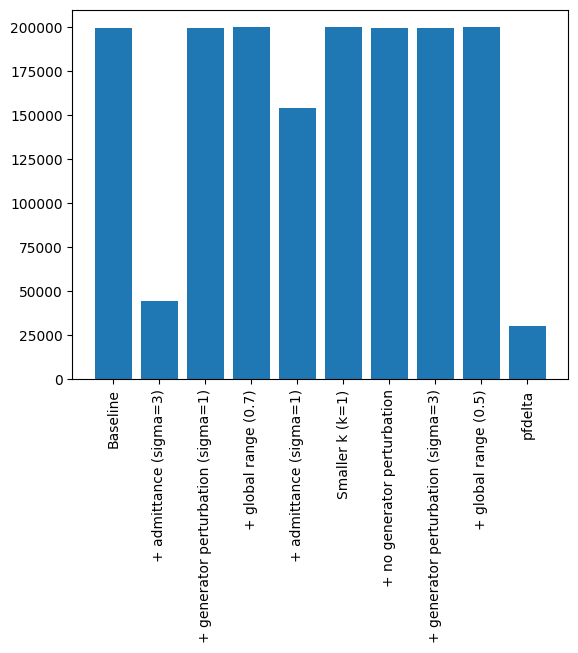

In [27]:
n_scenarios = {}
for lab, df in ALL_DFS.items():
    n_scenarios[lab] = df.scenario.max()

# plot n_scenarios
plt.bar([description[k] for k in n_scenarios.keys()], n_scenarios.values())
# rotate labels
plt.xticks(rotation=90)
plt.show()





In [28]:
versions.keys()

dict_keys(['baseline_perturbations_lines_only_k_5', 'baseline_perturbations_lines_only_k_5_sigma_3', 'baseline_perturbations_lines_only_k_5_generator_perturbation_1', 'baseline_perturbations_lines_only_k_5_global_range_0.7', 'baseline_perturbations_lines_only_k_5_sigma_1', 'baseline_perturbations_lines_only', 'baseline_perturbations_lines_only_k_5_generator_perturbation_none', 'baseline_perturbations_lines_only_k_5_generator_perturbation_3', 'baseline_perturbations_lines_only_k_5_global_range_0.5', 'pfdelta'])

In [29]:


def plot_versions(feature, selected_versions):


    grouped = {lab: df.groupby("bus")[feature] for lab, df in dfs.items() if lab in selected_versions}
    bus_types = dfs[REFERENCE_VERSION].groupby("bus")[["PQ", "PV", "REF"]].first().values
    bus_types = np.array(["PQ" if t[0] == 1 else "PV" if t[1] == 1 else "REF" for t in bus_types])

    fig, ax = plt.subplots(figsize=(12, 6))

    labels = list(grouped.keys())
    m = len(FIXED_BUSES)
    k = len(labels)
    base_positions = range(m)
    width = 0.7 / max(k, 1)
    offsets = [(i - (k - 1) / 2.0) * width for i in range(k)]
    COLORS = ["red", "blue", "green", "orange", "purple", "brown"]

    for i, lab in enumerate(labels):
        per_bus_data = [grouped[lab].get_group(b).values for b in FIXED_BUSES]
        positions = [p + offsets[i] for p in base_positions]
        
        
        bp = ax.boxplot(
            per_bus_data,
            positions=positions,
            widths=width * 0.9,
            showfliers=True,
            patch_artist=True,
            medianprops=dict(linewidth=1.5),
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(COLORS[i % len(COLORS)])
            patch.set_alpha(0.5)

    ax.set_title(f"{feature} distribution across buses", fontsize=14)
    ax.set_ylabel(feature, fontsize=14)
    ax.set_xticks(list(base_positions))
    ax.set_xticklabels([f"Bus {b} {bus_types[b]}" for b in FIXED_BUSES], 
                       rotation=45, ha="right", fontsize=14)
    
    ax.grid(True, axis="y", alpha=0.3)
    legend_patches = [mpatches.Patch(color=COLORS[i % len(COLORS)], label=description[lab]) 
                     for i, lab in enumerate(labels)]
    ax.legend(handles=legend_patches, title="Dataset version", loc="best", fontsize=14)

    plt.tight_layout()
    plt.savefig("boxplot.pdf")
    plt.show()

def plot_spider(selected_versions):
    features = ["Vm", "Va", "Pd", "Qd", "Pg", "Qg"]
    labels = list(selected_versions)
    COLORS = ["red", "blue", "green", "orange", "purple", "brown"]
    
    df_less_scenarios = {lab: df[df.scenario.isin(np.random.randint(0, num_samples, size=df.scenario.max()))] 
                        for lab, df in ALL_DFS.items() if lab in selected_versions}
    

    
    grouped_std = {lab: df.groupby("bus")[features].std() for lab, df in df_less_scenarios.items()}
    grouped_mean = {lab: df.groupby("bus")[features].mean() for lab, df in df_less_scenarios.items()}

    stats = {}
    for lab in labels:
        vals = []
        for f in features:
            if f == "Va":
                grouped_std[lab][f] = np.deg2rad(grouped_std[lab][f])
                grouped_mean[lab][f] = np.deg2rad(grouped_mean[lab][f])
            mean_std = grouped_std[lab][f].mean()
            vals.append(mean_std)
        stats[lab] = vals
    
    df_stats = pd.DataFrame(stats).T
    df_stats.columns = features
    df_stats = df_stats.div(df_stats.max(axis=0), axis=1)

    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for i, lab in enumerate(labels):
        values = df_stats.loc[lab].to_list()
        values += values[:1]
        ax.plot(angles, values, color=COLORS[i % len(COLORS)], linewidth=2, label=description[lab])
        ax.fill(angles, values, color=COLORS[i % len(COLORS)], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=14)
    ax.set_title("Data diversity across datasets", y=1.1, fontsize=14)
    ax.grid(True)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=14)
    plt.tight_layout()
    plt.savefig("spider_plot.pdf")
    plt.show()


version_multi = widgets.SelectMultiple(
    options=[(description[k], k) for k in versions.keys()],  # label, value pairs
    value=list(versions.keys()),  # values must match the 2nd element of options
    description="Versions",
    rows=min(6, len(versions)),
    layout=widgets.Layout(width="300px"),
)

feature_toggle = widgets.ToggleButtons(
    options=["Vm", "Va", "Pd", "Qd", "Pg", "Qg"],
    value="Pg",
    description="Feature",
)



out = widgets.Output()

def _on_change(_=None):
    with out:
        out.clear_output(wait=True)
        if not version_multi.value:
            print("Select at least one dataset version.")
            return
        plot_versions(
            feature_toggle.value,
            list(version_multi.value),
        )
        plot_spider(list(version_multi.value), )



# controls setup
controls = widgets.HBox([version_multi, widgets.VBox([feature_toggle])])
display(controls, out)

# Observe widget changes
version_multi.observe(_on_change, names="value")
feature_toggle.observe(_on_change, names="value")


Output()